<a href="https://colab.research.google.com/github/jdbj89/colab_repo/blob/main/TextClassifier_Final_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd

dataPath="/content/drive/MyDrive/Data_Text/"

df0 = pd.read_csv(dataPath+"data_0.csv")
df1 = pd.read_csv(dataPath+"data_1.csv")
df2 = pd.read_csv(dataPath+"data_2.csv")
df3 = pd.read_csv(dataPath+"data_3.csv")
df4 = pd.read_csv(dataPath+"data_4.csv")

df0.drop(df0.index[0], inplace=True) #Se borra el primer dato por que es un dato aislado y no esta dentro del rango estipulado --JD

dfaux=df4[df4["Id Num"]<=20800]

dfTest=df4[df4["Id Num"]>20800].reset_index(drop=True)

dfTest=dfTest[dfTest['Type']!="none"].reset_index(drop=True)
dfTest=dfTest[dfTest['Type']!="history"].reset_index(drop=True)

frames = [df0, df1, df2, df3, dfaux]
RawData = pd.concat(frames).reset_index(drop=True) #ojo importante reiniciar los indices, tuve un grave error sin eso --JD

RawData.drop_duplicates(inplace = True) #En el proceso de recopilacion de la info se duplico un archivo por eso se borra --JD

RawData= RawData[RawData['Type']!="none"].reset_index(drop=True)
RawData= RawData[RawData['Type']!="history"].reset_index(drop=True)

display(RawData)
# RawData.head

,Id Num,Page,Type,Text
0,17002,1,medicine,INSTITUTO CALDENSE DE MEDICINA DEL DOLOR SAS\n...
1,17003,1,procedure,Clínica\nEl Rosario\nEdgar Fabián Manosalva Co...
2,17004,1,procedure,http://186.154.88.68/UROSOFT/cache/Gs7qcT.html...
3,17004,2,procedure,http://186.154.88.68/UROSOFT/cache/Gs7qcT.html...
4,17006,1,procedure,Keralty\nINVERSIONES CLINITAS S.A.\nFecha: 28/...
...,...,...,...,...
3205,20794,1,procedure,cas Centro Médico\nFECHA 7.2.2021\nLaura Escob...
3206,20795,1,procedure,Dr. Alberto Quintero Molina.\nPACIENTE: CECILI...
3207,20797,1,procedure,ISO 9001:2008\nBUREAU VERITAS\nCertification\n...
3208,20798,1,medicine,Keralty\nINVERSIONES CLINITAS S.A.\nFecha: 17/...


In [ ]:
import numpy as np
import sklearn
from io import StringIO


RawData['category_id'] = RawData['Type'].factorize()[0]  # otorga un valor para cada tipo de dato. 0-procedure 1-history 2-medicine 3-none --JD

category_id_df = RawData[['Type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Type']].values)

print(category_id_df)
print(category_to_id)
print(id_to_category)

        Type  category_id
0   medicine            0
1  procedure            1
{'medicine': 0, 'procedure': 1}
{0: 'medicine', 1: 'procedure'}


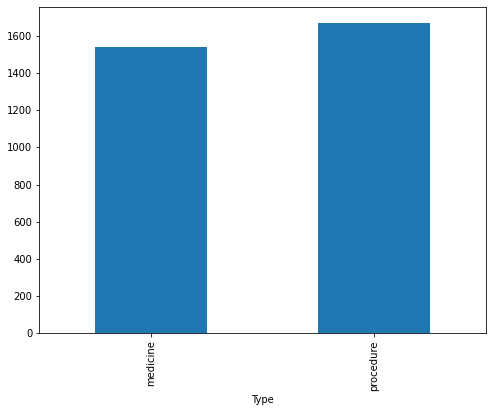

Type
medicine     1539
procedure    1671
Name: Text, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

RawData.groupby('Type').Text.count().plot.bar(ylim=0)
plt.show()

print(RawData.groupby('Type').Text.count())

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import pickle

# sublinear_df is set to True to use a logarithmic form for frequency.
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords.words("spanish"))
#vectorizer = TfidfVectorizer(min_df=5, norm='l2', ngram_range=(1, 2))

tfidf = vectorizer.fit(RawData["Text"].values.astype('U'))

features = vectorizer.fit_transform(RawData.Text).toarray()
labels = RawData.category_id
features.shape

(3210, 14715)

In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, RawData.index, test_size=0.2, random_state=0)

model = LinearSVC()
model.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
model_path = dataPath + "model_v4.pickle"
tfidf_path = dataPath + "vectorizer_v4.pickle"
pickle.dump(model, open(model_path, 'wb'))
pickle.dump(tfidf, open(tfidf_path, "wb"))

In [ ]:
tfidf_loaded = pickle.load(open(tfidf_path,'rb'))
model_loaded = pickle.load(open(model_path,'rb'))
pred = model_loaded.predict(tfidf_loaded.transform(["Solicitud de procedimiento TAC abdominal paciente con cancer pulmonar"]))[0]
print ("predicted class:", id_to_category[pred])


predicted class: procedure


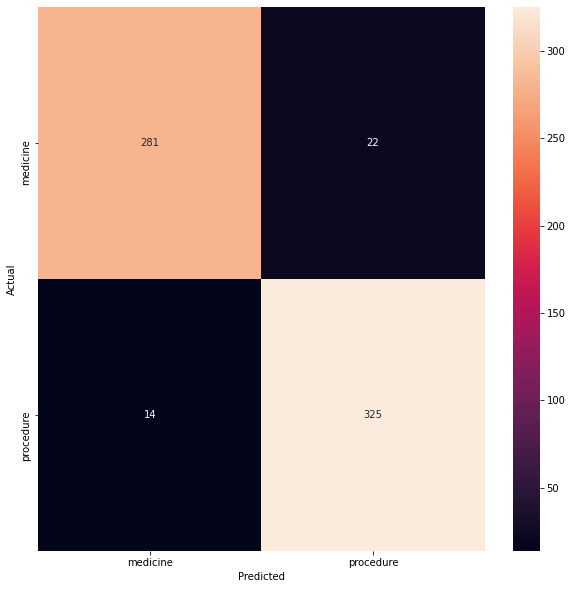

              precision    recall  f1-score   support

    medicine       0.95      0.93      0.94       303
   procedure       0.94      0.96      0.95       339

    accuracy                           0.94       642
   macro avg       0.94      0.94      0.94       642
weighted avg       0.94      0.94      0.94       642



In [ ]:
import seaborn as sns
from sklearn import metrics

y_pred = model_loaded.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred, target_names=RawData['Type'].unique()))


In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print ("valor actual = {}".format(actual))
      print ("valor predicted = {}".format(predicted))
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(RawData.iloc[indices_test[(y_test == actual) & (y_pred == predicted)]])
      print('')

valor actual = 1
valor predicted = 0
'procedure' predicted as 'medicine' : 14 examples.


,Id Num,Page,Type,Text,category_id
582,17711,1,procedure,Mun IN\nCONTINUA DE GLUCOSA VIERMEE STYLE\nLa ...,1
2427,19809,1,procedure,Dra. Lisseth Fernanda Marin Carrillo\nMedicina...,1
764,17895,1,procedure,Feb. 24 2021\n12.\nCar Shows\nAMPLIACION INFOR...,1
2834,20380,1,procedure,Clínica\nColsanitas\nFECHA\nNOMBRE:\nisloz/202...,1
1846,19155,1,procedure,Para uso exclusivo de afiliados a la EPS Sanit...,1
2329,19716,1,procedure,... Claro\n3:49 PM\n@ 56%\nBack FORMULA LOLA O...,1
499,17624,1,procedure,CLAUDIA VÉLE2 Campuzano\nDermatologa\n27\n2021...,1
1526,18741,1,procedure,Colsanitas Centro Médico\nFECHA:\n02-\nLowo\n2...,1
3065,20647,1,procedure,Carlos Alberto Navas Cardozo Md\nNeurólogo\nEn...,1
2175,19530,1,procedure,A.M.Mulder Seite\nALAMA MNOHOME &\nFORMULA MED...,1



valor actual = 0
valor predicted = 1
'medicine' predicted as 'procedure' : 22 examples.


,Id Num,Page,Type,Text,category_id
1217,18382,1,medicine,solo palta autorizar\nla espironolactona\nporq...,0
1768,19040,1,medicine,"C\nSantiago\nGuerrero\nOrtopedia, traumatologí...",0
3160,20742,1,medicine,Mauricic\nArang\nCon Strea UAM\nNombre\nBLANCA...,0
1881,19193,1,medicine,Fecha y Hora de Solicitud\nConsecutivo\n13/02/...,0
295,17396,1,medicine,DR. RAFAEL A. LOBELO GARCIA\nINTERNISTA-NEUMOL...,0
1912,19226,1,medicine,Dr. Carlos Francisco Diaz B.\nOFTALMOLOGÍA\nUN...,0
1032,18176,1,medicine,Colsanitas Centro Médico\nFECHA:\n10102/2001 6...,0
2019,19351,1,medicine,Dra. Catherine Reyes Rodríguez\nCirugía Ortopé...,0
1687,18944,1,medicine,Colsanitas Centro Médico\nFECHA:\nFebrew\n12/2...,0
1412,18597,1,medicine,DRA. SYLVIA PÁEZ MOYA\nMEDICINA INTERNA - NEUM...,0


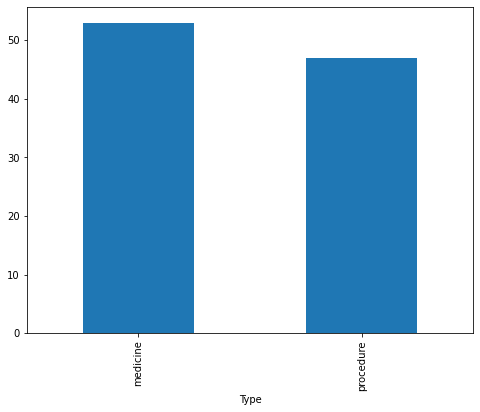

Type
medicine     53
procedure    47
Name: Text, dtype: int64


In [ ]:
dfTest['category_id'] = dfTest['Type'].map(category_to_id)
# display(dfTest)

fig = plt.figure(figsize=(8,6))

dfTest.groupby('Type').Text.count().plot.bar(ylim=0)
plt.show()

print(dfTest.groupby('Type').Text.count())

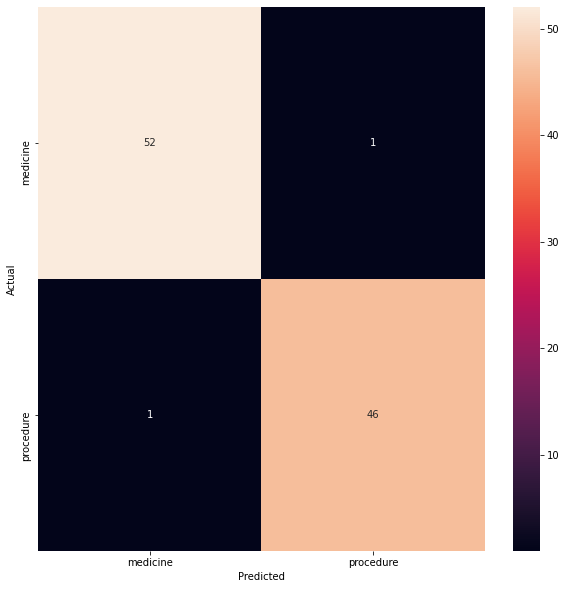

              precision    recall  f1-score   support

   procedure       0.98      0.98      0.98        53
    medicine       0.98      0.98      0.98        47

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:
features_val = tfidf_loaded.transform(dfTest.Text).toarray()
labels_val = dfTest.category_id
features_val.shape

y_pred_val = model_loaded.predict(features_val)

conf_mat2 = confusion_matrix(labels_val, y_pred_val)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat2, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(labels_val, y_pred_val, target_names=dfTest['Type'].unique()))

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
#vectorizer = TfidfVectorizer(min_df=5, norm='l2', ngram_range=(1, 2))

tfidf = vectorizer.fit(RawData["Text"].values.astype('U'))

features = vectorizer.fit_transform(RawData.Text).toarray()
labels = RawData.category_id
features.shape

(3210, 15973)

In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, RawData.index, test_size=0.2, random_state=0)

model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
model_path = dataPath + "model_v5.pickle"
tfidf_path = dataPath + "vectorizer_v5.pickle"
pickle.dump(model, open(model_path, 'wb'))
pickle.dump(tfidf, open(tfidf_path, "wb"))

In [ ]:
tfidf_loaded = pickle.load(open(tfidf_path,'rb'))
model_loaded = pickle.load(open(model_path,'rb'))
pred = model_loaded.predict(tfidf_loaded.transform(["Solicitud de procedimiento TAC abdominal paciente con cancer pulmonar"]))[0]
print ("predicted class:", id_to_category[pred])

predicted class: procedure


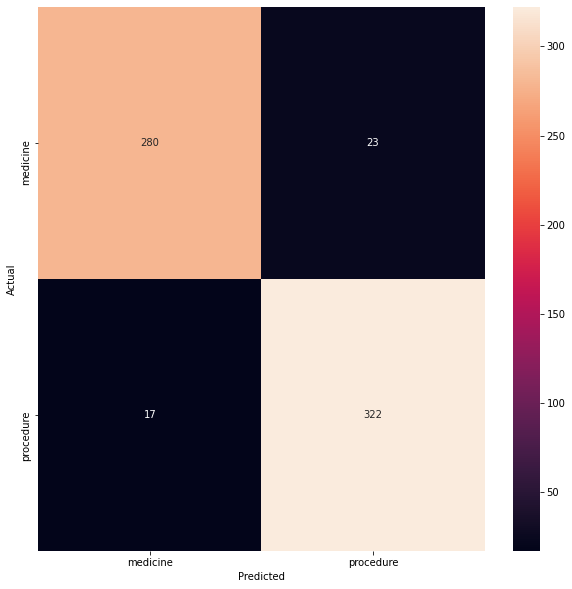

              precision    recall  f1-score   support

    medicine       0.94      0.92      0.93       303
   procedure       0.93      0.95      0.94       339

    accuracy                           0.94       642
   macro avg       0.94      0.94      0.94       642
weighted avg       0.94      0.94      0.94       642



In [ ]:
import seaborn as sns
from sklearn import metrics

y_pred = model_loaded.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred, target_names=RawData['Type'].unique()))

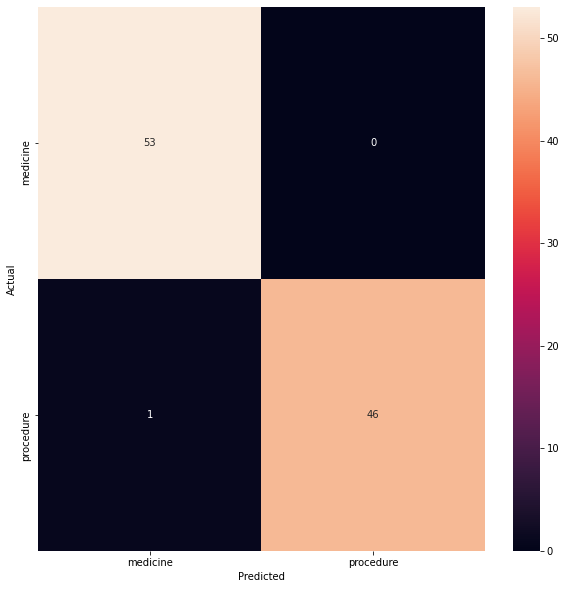

              precision    recall  f1-score   support

   procedure       0.98      1.00      0.99        53
    medicine       1.00      0.98      0.99        47

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
features_val = tfidf_loaded.transform(dfTest.Text).toarray()
labels_val = dfTest.category_id
features_val.shape

y_pred_val = model_loaded.predict(features_val)

conf_mat2 = confusion_matrix(labels_val, y_pred_val)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat2, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(labels_val, y_pred_val, target_names=dfTest['Type'].unique()))